# Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

# Calculating Bollinger Bands

In [3]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [4]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [5]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [6]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Get Nasdaq 100 Tickers

In [7]:
def get_nasdaq100():
    tickers = []
    headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
    res = requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100", headers=headers)
    main_data = res.json()['data']['data']['rows']
    for company in main_data:
        tickers.append(company['symbol'])
    return tickers

# Screener Algorithm

In [8]:
def screener(company):
    calls = ''
    puts = ''
    #fails = ''
    one_day_streak = ''
    two_days_streak = ''
    three_days_streak = ''
    four_days_streak = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day ==-5:
                calls = ''
                puts = ''
                four_days_streak = ticker + ' - ' + current_status
            elif day ==-4:
                calls = ''
                puts = ''
                three_days_streak = ticker + ' - ' + current_status
            elif day ==-3:
                calls = ''
                puts = ''
                two_days_streak = ticker + ' - ' + current_status
            elif day ==-2:
                calls = ''
                puts = ''
                one_day_streak = ticker + ' - ' + current_status
            break
    return calls,puts,one_day_streak,two_days_streak,three_days_streak,four_days_streak

# Screener

In [9]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []
ones = []
twos = []
threes = []
fours = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_ones!='':
            ones.append(company_ones)
        if company_twos!='':
            twos.append(company_twos)
        if company_threes!='':
            threes.append(company_threes)
        if company_fours!='':
            fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check Nasdaq-100

In [10]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(get_nasdaq100)
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (3): ['MNST', 'EXC', 'KHC']
Puts (5): ['PCAR', 'CDNS', 'PEP', 'TMUS', 'MELI']
4-days Streak (2): ['SNPS - put', 'META - call']
3-days Streak (2): ['CTAS - put', 'DLTR - put']
2-days Streak (4): ['AMGN - put', 'ADSK - put', 'FANG - put', 'ZM - put']
1-day Streak (15): ['ROST - call', 'FISV - call', 'CSCO - put', 'SIRI - put', 'BKNG - call', 'AMD - put', 'HON - put', 'SGEN - call', 'GOOGL - put', 'ATVI - call', 'GOOG - put', 'BKR - put', 'KDP - put', 'AMZN - put', 'COST - put']


# Check S&P500

In [11]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(sp500)
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

ValueError: Length of values (14) does not match length of index (13)

# Check individual stock

In [12]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('NVDA')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (0): []
Puts (0): []
4-days Streak (0): []
3-days Streak (0): []
2-days Streak (0): []
1-day Streak (0): []


# Get pre/post market prices

In [13]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = f'{ticker} Premarket: {get_premarket_price(ticker)}'
    elif is_postmarket(current_hour):
        data = f'{ticker} Postmarket: {get_postmarket_price(ticker)}'
    else:
        data = f'{ticker} Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('CL',current_hour)

CL Not pre/post market


# Plotter

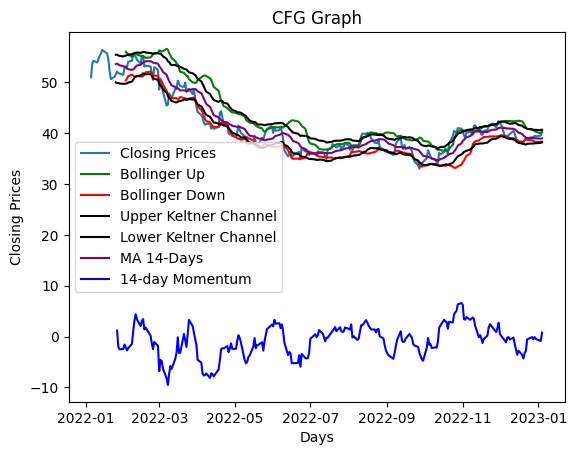

In [14]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'CFG'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()

In [15]:
get_expiration_dates("KHC")

['January 6, 2023',
 'January 13, 2023',
 'January 20, 2023',
 'January 27, 2023',
 'February 3, 2023',
 'February 10, 2023',
 'February 17, 2023',
 'April 21, 2023',
 'July 21, 2023',
 'January 19, 2024',
 'June 21, 2024',
 'January 17, 2025']

In [16]:
get_calls('KHC','February 17, 2023')

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,KHC230217C00035000,2023-01-04 3:10PM EST,35.0,6.56,6.50,6.70,0.0,-,20,21,41.41%
1,KHC230217C00037500,2023-01-04 2:02PM EST,37.5,4.25,4.25,4.45,0.0,-,82,420,35.35%
2,KHC230217C00040000,2023-01-04 3:44PM EST,40.0,2.21,2.28,2.37,0.0,-,64,577,28.27%
3,KHC230217C00042500,2023-01-05 9:52AM EST,42.5,0.94,0.89,0.95,0.1,+11.90%,2119,3154,24.90%
4,KHC230217C00045000,2023-01-04 3:29PM EST,45.0,0.25,0.24,0.28,0.0,-,4,601,23.58%
5,KHC230217C00047500,2023-01-04 2:33PM EST,47.5,0.05,0.05,0.08,0.0,-,10,14,24.32%
